<a id=top-page></a>
# `pykitPIV` demo: Learn to locate sources/sinks in a 2D PIV experiment using reinforcement learning

## Double deep Q-network with memory replay

In this Jupyter notebook, we show how the available functionalities from the machine learning module (`pykitPIV.ml`) can be used to train a reinforcement learning (RL) agent to navigate the virtual PIV camera towards sources/sinks in a radial flow.

The agent can perform one of five actions:

- Move up
- Move down
- Move right
- Move left
- Stay

on the virtual camera, thereby with each step moving the virtual PIV camera by $N$ pixels.

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#initializations">Initializations</a></li>
    <li><a href="#generate-velocity-field">Generate random velocity field to advect the particles</a></li>
    <li><a href="#add-movement">Add movement to particles</a></li>
        <ul>
        <li><a href="#add-movement-update-time-sep">Update time separation</a></li>
        <li><a href="#add-movement-visualize">Visualize the PIV image pair</a></li>
        </ul>
    <li><a href="#save">Save the dataset</a></li>
    <li><a href="#upload">Upload the saved datasets</a></li>
</ol>
<p></p>
</div>
<br>

***

In [1]:
from pykitPIV.ml import PIVEnv, CameraAgentDoubleDQN, Rewards, Cues, plot_trajectory
from pykitPIV.flowfield import compute_q_criterion, compute_divergence
from pykitPIV import ParticleSpecs, FlowFieldSpecs, MotionSpecs, ImageSpecs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import cmcrameri.cm as cmc
import numpy as np
import onnxruntime
import tensorflow as tf
import pandas as pd
import h5py
import torch
import sys, os
import time
import copy as cp

2025-05-08 11:53:30.631263: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
save_images = False
filename = None

In [2]:
action_colors = cmc.batlow(np.linspace(0, 1, 5))
cmap_actions = ListedColormap(action_colors)

In [3]:
interrogation_window_size = (100,100)
interrogation_window_size_buffer = 10

***

## Initializations

### Prepare specifications for pykitPIV parameters

In [4]:
particle_spec = ParticleSpecs(diameters=(1, 1),
                              distances=(2, 2),
                              densities=(0.4, 0.4),
                              diameter_std=0,
                              seeding_mode='random')

print(particle_spec)

ParticleSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
diameters=(1, 1),
distances=(2, 2),
densities=(0.4, 0.4),
diameter_std=0,
seeding_mode='random',
random_seed=None)


In [5]:
flowfield_spec = FlowFieldSpecs(size=(200,500),
                                flowfield_type='radial',
                                radial_epsilon=1e-6,
                                radial_source=True,
                                radial_sigma=20,
                                radial_imposed_source_location=None,
                                displacement=(2, 2))

print(flowfield_spec)

FlowFieldSpecs(n_images=1,
size=(200, 500),
size_buffer=10,
random_seed=None,
flowfield_type='radial',
gaussian_filters=(10, 10),
n_gaussian_filter_iter=10,
displacement=(2, 2),
radial_source=True,
radial_imposed_source_location=None,
radial_sigma=20,
radial_epsilon=1e-06,
apply_SLM=False,
integral_time_scale=1,
sigma=1,
n_stochastic_particles=1000000,
n_iterations=100)


In [6]:
motion_spec = MotionSpecs(n_steps=10,
                          time_separation=1,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

MotionSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
n_steps=10,
time_separation=1,
particle_loss=(0, 0),
particle_gain=(0, 0),
random_seed=None)


In [7]:
image_spec = ImageSpecs(exposures=(0.98, 0.98),
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False)

print(image_spec)

ImageSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
exposures=(0.98, 0.98),
maximum_intensity=65535,
laser_beam_thickness=1,
laser_over_exposure=1,
laser_beam_shape=0.95,
no_laser_plane=False,
alpha=0.125,
extend_gaussian=1,
covariance_matrix=None,
clip_intensities=True,
normalize_intensities=False)


### Prepare the CNN-based inference model for PIV images:

In [8]:
class ONNXmodel:
    
    def __init__(self,
                 onnx_file_path):
        
        self.name = "ONNX"
        self.providers = ['CPUExecutionProvider']
        self.session = onnxruntime.InferenceSession(onnx_file_path, 
                                                    None,
                                                    providers=self.providers)

        self.input_name = self.session.get_inputs()[0].name  
        print('Input Name:', self.input_name)   
 
    def inference(self, x):
        
        output = self.session.run([], {self.input_name:x/np.max(x)})[0] 
      
        return output

    def empty(self):
        
         with torch.no_grad():
            torch.cuda.empty_cache()

In [9]:
model_file = '../Lima_L4_PAD_SR2_dyn.onnx'
print("model:", model_file, '  exist:', os.path.exists(model_file))

model: ../Lima_L4_PAD_SR2_dyn.onnx   exist: True


In [10]:
lima_inference_model = ONNXmodel(model_file)

Input Name: Input


***

## Create the RL environment

Define the cues that the RL agent effectively senses and learns from:

In [11]:
cues_obj = Cues(sample_every_n=10, 
                normalize_displacement_vectors=False)

cues_function = cues_obj.sampled_vectors

Initialize the `Gymnasium`-based virtual wind tunnel environment using the `PIVEnv` class:

In [12]:
env = PIVEnv(interrogation_window_size=interrogation_window_size,
             interrogation_window_size_buffer=interrogation_window_size_buffer,
             cues_function=cues_function,
             particle_spec=particle_spec,
             motion_spec=motion_spec,
             image_spec=image_spec,
             flowfield_spec=flowfield_spec,
             inference_model=None,
             random_seed=None)

In [13]:
camera_position, cues = env.reset(imposed_camera_position=np.array([40, 20]), regenerate_flowfield=True)

In [14]:
cues.shape

(1, 200)

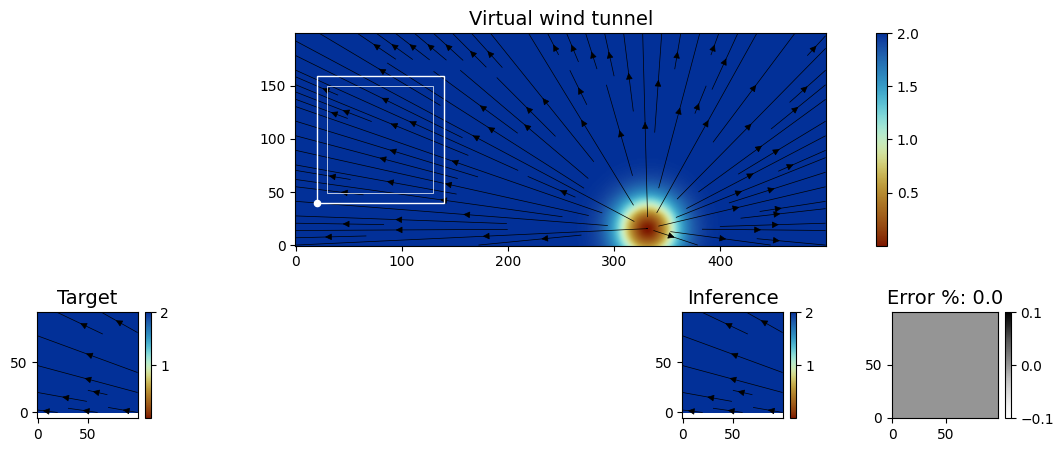

In [15]:
plt = env.render(quantity=None,
                 camera_position=camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=1,
                 streamplot_color='k',
                 streamplot_linewidth=0.5,
                 figsize=(13,5), 
                 filename='ml_PIVEnv_render.png')

***

## Create and train the RL agent

We will train the RL agent on 1000 episodes, where at the beginning of each new episose, a new radial field is generated:

In [16]:
n_episodes = 5000

We will let the RL agent take 20 steps (camera movements) per episode:

In [17]:
n_iterations = 20

Each step will be magnified 10 times, i.e., instead of the step being a movement of camera by 1px, it will be a movement by 10px:

In [18]:
magnify_step = 10

Define the discount factor for the future rewards, $\gamma$:

In [19]:
discount_factor = 0.95

Specify the parameters for the $\varepsilon$-greedy policy:

In [20]:
epsilon_start = 0.5
epsilon_end = 0.0
n_episodes_epsilon_decay = 4800

Specify the parameters for the learning rate decay:

In [21]:
initial_learning_rate = 0.001
alpha_lr = 0.01
n_episodes_learning_rate_decay = 5000

Specify the batch size:

In [22]:
batch_size = 32

Specify the memory size for memory replay:

In [23]:
memory_size = 200

Specify the number of epochs for training on each step in the environment:

In [24]:
n_epochs = 1

Specify the kernel initializer for the weights in the Q-network:

In [25]:
kernel_initializer = tf.keras.initializers.RandomUniform

Specify the gradient descent optimizer to use, it can be `'RMSprop'` or `'Adam'`:

In [26]:
optimizer = 'Adam'

Define the exploration probability decay:

In [27]:
def epsilon_decay(episode, 
                  epsilon_start,
                  epsilon_end,
                  n):
    
    if episode < n:
        return epsilon_start - (episode / n) * (epsilon_start - epsilon_end)
    else:
        return epsilon_end

In [28]:
exploration_probabilities = []

for i in range(0,n_episodes):

    exploration_probabilities.append(epsilon_decay(i, epsilon_start, epsilon_end, n=n_episodes_epsilon_decay))

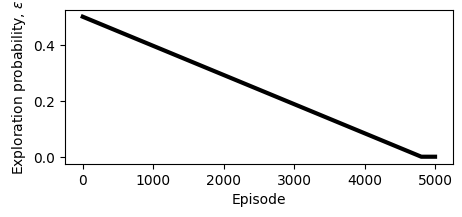

In [29]:
plt.figure(figsize=(5,2))
plt.plot(exploration_probabilities, c='k', lw=3)
plt.xlabel('Episode')
plt.ylabel(r'Exploration probability, $\varepsilon$');

Define the cosine learning rate decay:

In [30]:
def learning_rate_decay(episode, 
                        initial_learning_rate, 
                        alpha_lr, 
                        n):
    
    episode = np.min([episode, n])
    cosine_decay = 0.5 * (1 + np.cos(np.pi * episode / n))
    decayed = (1 - alpha_lr) * cosine_decay + alpha_lr
    
    return initial_learning_rate * decayed

In [31]:
decayed_learning_rates = []

for i in range(0,n_episodes):

    decayed_learning_rates.append(learning_rate_decay(i,
                                                      initial_learning_rate=initial_learning_rate, 
                                                      alpha_lr=alpha_lr, 
                                                      n=n_episodes_learning_rate_decay))

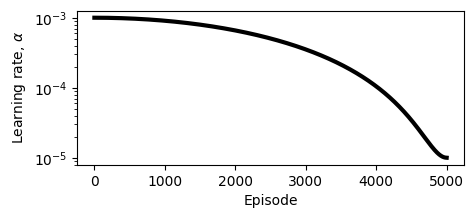

In [32]:
plt.figure(figsize=(5,2))
plt.semilogy(decayed_learning_rates, c='k', lw=3)
plt.xlabel('Episode')
plt.ylabel(r'Learning rate, $\alpha$');

We define the architecture for the deep Q-network:

In [33]:
size_of_hidden_unit = int(env.n_cues/2)
size_of_hidden_unit

100

In [34]:
class QNetwork(tf.keras.Model):

    def __init__(self, n_actions, kernel_initializer):

        super(QNetwork, self).__init__()

        self.dense1 = tf.keras.layers.Dense(env.n_cues, activation='relu', kernel_initializer=kernel_initializer)
        self.dense2 = tf.keras.layers.Dense(size_of_hidden_unit, activation='relu', kernel_initializer=kernel_initializer)
        self.dense3 = tf.keras.layers.Dense(size_of_hidden_unit, activation='relu', kernel_initializer=kernel_initializer)
        self.output_layer = tf.keras.layers.Dense(n_actions, activation='relu', kernel_initializer=kernel_initializer)

    def call(self, state):

        x = self.dense1(state)
        x = self.dense2(x)
        x = self.dense3(x)

        return self.output_layer(x)

Initialize the camera agent using the `CameraAgent` class:

In [35]:
ca = CameraAgent(env=env,
                 target_q_network=QNetwork(env.n_actions, kernel_initializer),
                 online_q_network=QNetwork(env.n_actions, kernel_initializer),
                 memory_size=memory_size,
                 batch_size=batch_size,
                 n_epochs=n_epochs,
                 learning_rate=initial_learning_rate,
                 optimizer='Adam',
                 discount_factor=discount_factor)

The uploaded environment has 5 actions.


We are going to use the reward based on divergence:

In [36]:
rewards = Rewards(verbose=False)
reward_function = rewards.divergence

Define a transformation function for the reward which is appropriate to detecting regions of high divergence:

In [37]:
def reward_transformation(div):  
    return np.max(np.abs(div))

In [41]:
total_tic = time.perf_counter()

print()
print('- '*50)
print('Starting training the RL agent...\n')

tic = time.perf_counter()

iter_count = 0
total_rewards = []
current_lr = cp.deepcopy(initial_learning_rate)

batch_q_values_collected = np.zeros((1, env.n_actions))

log_every = 1

for episode in range(0, n_episodes):

    camera_position, cues = ca.env.reset(regenerate_flowfield=True)
    total_reward = 0

    # Before we start training the Q-network, only exploration is allowed:
    if len(ca.memory.buffer) >= batch_size:

        # Exploration probability decreases with training time:
        epsilon = epsilon_decay(episode=iter_count, 
                                epsilon_start=epsilon_start,
                                epsilon_end=epsilon_end,
                                n=n_episodes_epsilon_decay)

        # Decay the learning rate:
        current_lr = learning_rate_decay(episode=iter_count, 
                                         initial_learning_rate=initial_learning_rate, 
                                         alpha_lr=alpha_lr, 
                                         n=n_episodes_learning_rate_decay)
        
        iter_count += 1  # Only counts episodes that had Q-network trainings in them

    else:

        epsilon = 1.0

    if (episode) % log_every == 0:

        print(f'Episode: {episode + 1}')
        print(f'Epsilon: {epsilon:0.3f}')
        print('Learning rate: ' + str(current_lr))

    for i in range(0,n_iterations):

        action = ca.choose_action(cues,
                                  epsilon=epsilon)

        next_camera_position, next_cues, reward = ca.env.step(action,
                                                              reward_function=reward_function,
                                                              reward_transformation=reward_transformation,
                                                              magnify_step=magnify_step,
                                                              verbose=False)

        ca.remember(cues,
                    action,
                    reward,
                    next_cues)

        cues = next_cues
        total_reward += reward

        # Train the Q-network after each step, (but hold off with training until batch_size of samples is collected):
        if len(ca.memory.buffer) >= batch_size:

            ca.train(current_lr)

    batch_q_values = ca.online_q_network(cues).numpy()
    batch_q_values_collected = np.vstack((batch_q_values_collected, batch_q_values))

    # Synchronize the Q-networks only at the end of each episode:
    if len(ca.memory.buffer) >= batch_size:
        ca.update_target_network()
    
    if (episode) % log_every == 0:

        toc = time.perf_counter()

        print(f"Total Reward: {total_reward:0.1f}")
        print(f'This episode took: {(toc - tic):0.1f} sec.')
        print('- '*15)
        print()

        tic = time.perf_counter()

    total_rewards.append(total_reward)

batch_q_values_collected = batch_q_values_collected[1::,:]


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Starting training the RL agent...

Episode: 1
Epsilon: 1.000
Learning rate: 0.001
Total Reward: 0.2
This episode took: 0.1 sec.
- - - - - - - - - - - - - - - 

Episode: 2
Epsilon: 1.000
Learning rate: 0.001
Total Reward: 0.2
This episode took: 4.9 sec.
- - - - - - - - - - - - - - - 

Episode: 3
Epsilon: 0.500
Learning rate: 0.001
Total Reward: 1.4
This episode took: 8.6 sec.
- - - - - - - - - - - - - - - 

Episode: 4
Epsilon: 0.500
Learning rate: 0.0009999999022909196
Total Reward: 1.9
This episode took: 8.5 sec.
- - - - - - - - - - - - - - - 

Episode: 5
Epsilon: 0.500
Learning rate: 0.0009999996091637172
Total Reward: 0.2
This episode took: 8.7 sec.
- - - - - - - - - - - - - - - 

Episode: 6
Epsilon: 0.500
Learning rate: 0.0009999991206185081
Total Reward: 2.0
This episode took: 8.7 sec.
- - - - - - - - - - - - - - - 

Episode: 7
Epsilon: 0.500
Learning rate: 0.0009999984366554858
To

KeyboardInterrupt: 

Text(0, 0.5, 'MSE loss')

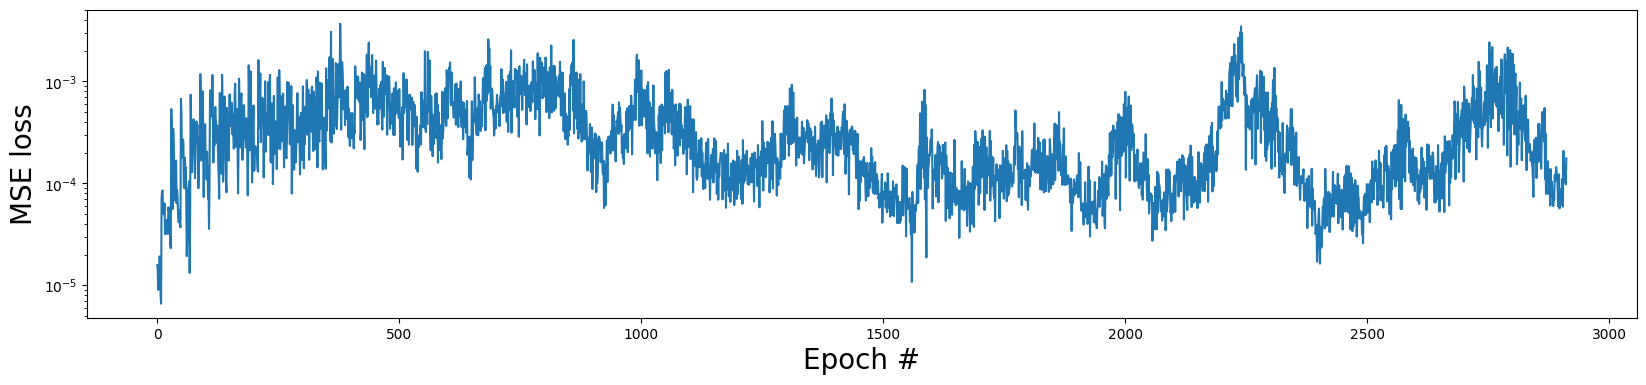

In [42]:
MSE_losses_collected = np.array(ca.MSE_losses).ravel()
plt.figure(figsize=(20,4))
plt.semilogy(MSE_losses_collected)
plt.xlabel('Epoch #', fontsize=20)
plt.ylabel('MSE loss', fontsize=20)

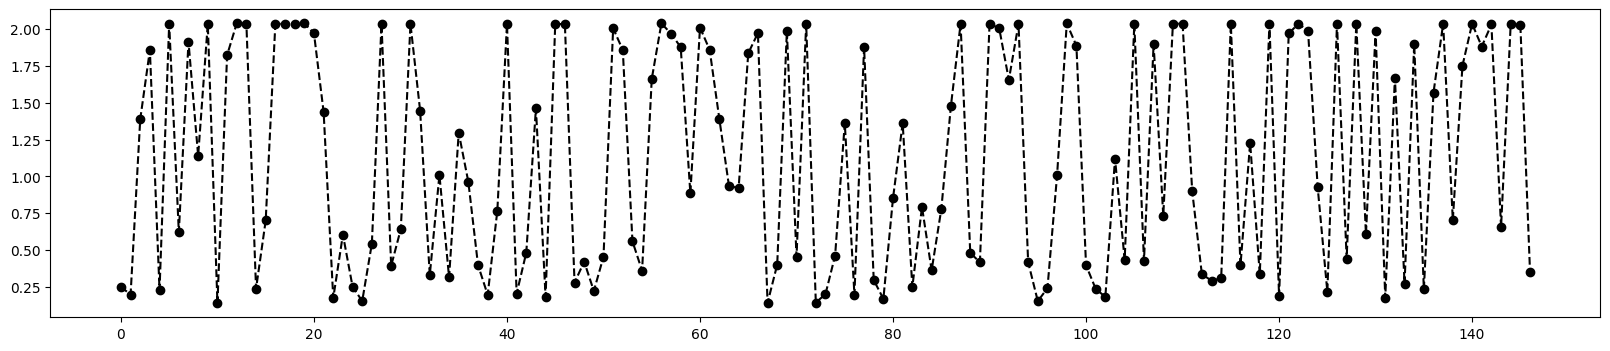

In [43]:
plt.figure(figsize=(20,4))
plt.plot(total_rewards, 'ko--')

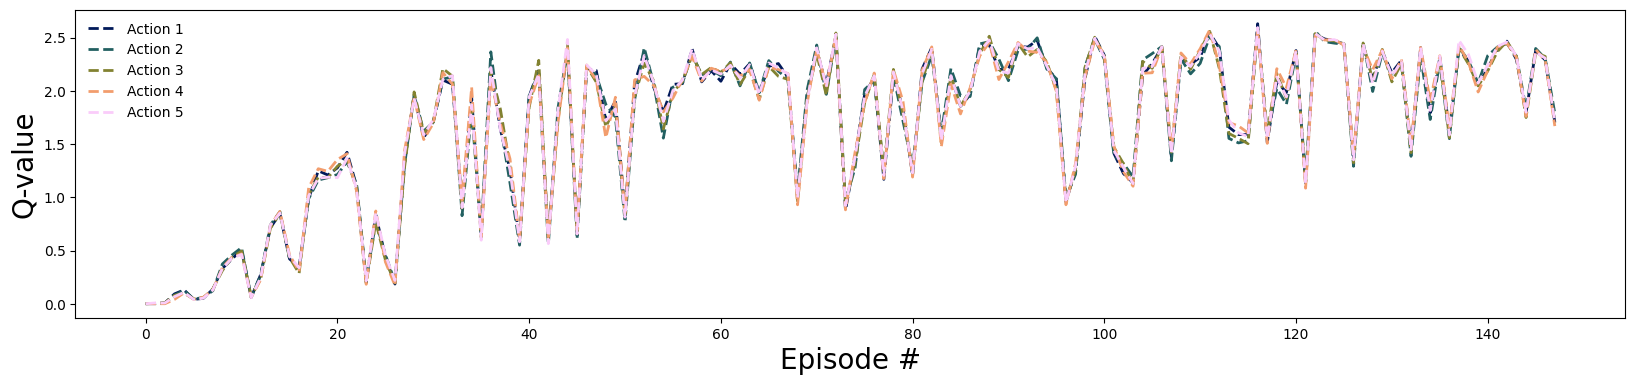

In [44]:
plt.figure(figsize=(20,4))
for i in range(0,5):
    plt.plot(batch_q_values_collected[:,i], '--', label='Action ' + str(i+1), color=action_colors[i], lw=2)
plt.xlabel('Episode #', fontsize=20)
plt.ylabel('Q-value', fontsize=20)
plt.legend(frameon=False)

In [45]:
ca.online_q_network.save('QNetwork.keras')

### Visualize the learned policy in the training environment

Create sparse samples of camera position on a uniform grid:

In [46]:
(_, _, H, W) = ca.env.flowfield.velocity_field_magnitude.shape
(H_adm, W_adm) = ca.env.admissible_observation_space
idx_H = [i for i in range(0, H_adm) if i % 2 == 0]
idx_W = [i for i in range(0, W_adm) if i % 2 == 0]
print(len(idx_H) * len(idx_W))

7600


In [47]:
tic = time.perf_counter()

learned_policy = np.ones((H,W)) * np.nan

for h in idx_H:
    for w in idx_W:

        camera_position = np.array([h, w])
        _, cues = ca.env.reset(imposed_camera_position=camera_position)
        q_values = ca.online_q_network(cues)
        action = np.argmax(q_values)
        learned_policy[h, w] = action

learned_policy = learned_policy[~np.isnan(learned_policy)]
learned_policy = learned_policy.reshape(len(idx_H), len(idx_W))

toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic):0.1f} sec.')

	Time it took: 30.3 sec.


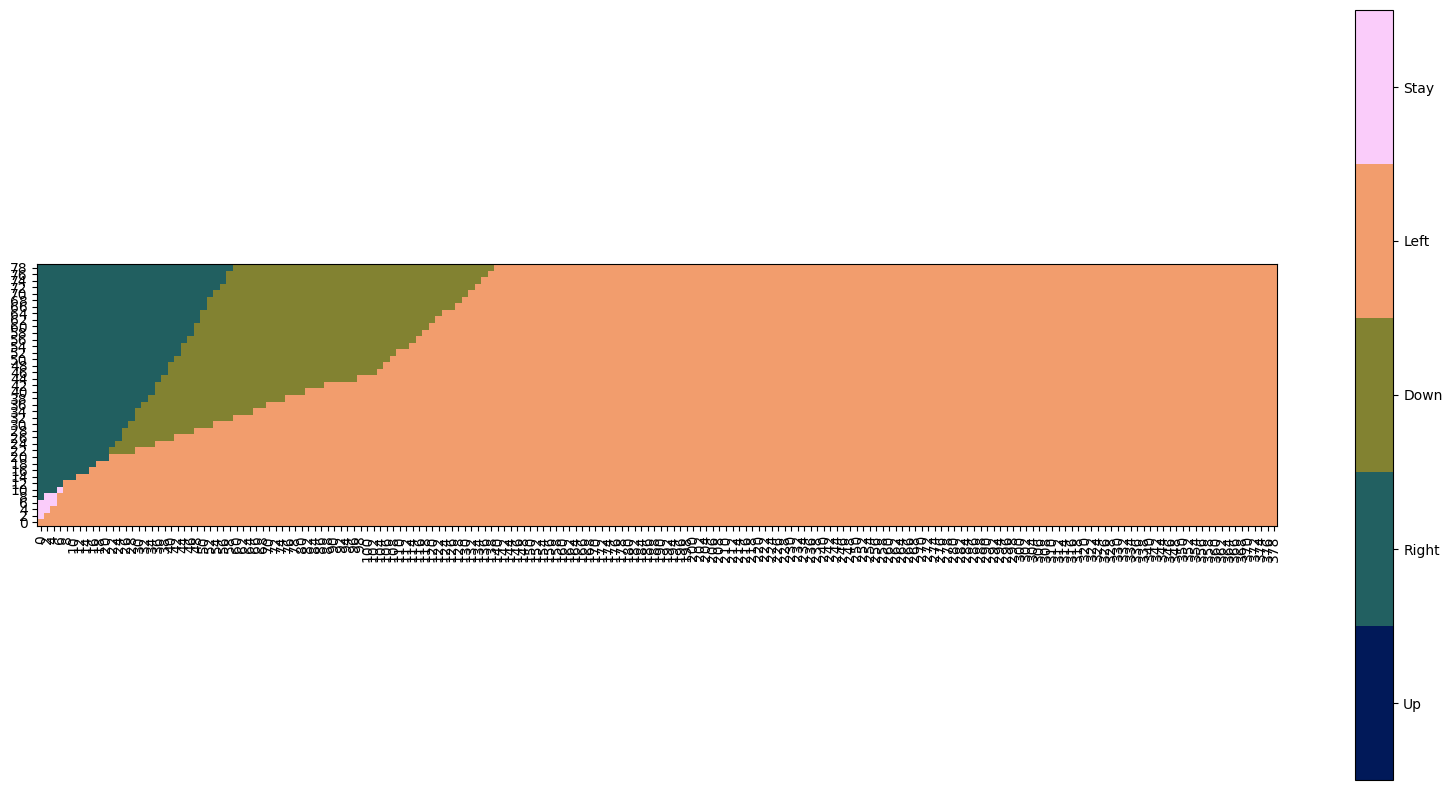

In [48]:
cluster_colors = cmc.batlow(np.linspace(0, 1, 5))
cmap = ListedColormap(cluster_colors)

plt.figure(figsize=(20,10))
plt.imshow(learned_policy, origin='lower', cmap=cmap_actions, vmin=0, vmax=4)
cbar = plt.colorbar()
cbar.set_ticks([4/5*(i+0.5) for i in range(0,5)])
cbar.set_ticklabels(list(ca.env.action_to_verbose_direction.values()))
plt.xticks([i for i in range(0,len(idx_W))], idx_W, rotation=90)
plt.yticks([i for i in range(0,len(idx_H))], idx_H);
plt.savefig('policy.png', dpi=300, bbox_inches='tight')

TypeError: Invalid shape (2,) for image data

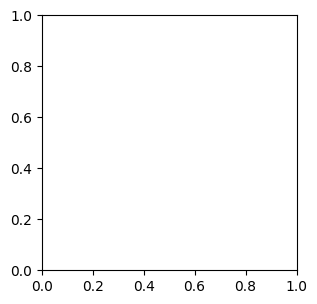

In [50]:
plt = env.render(camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=3,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(10,6), 
                 filename='final-environment.png')

***

## Test the trained agent on a new environment

In [51]:
particle_spec = ParticleSpecs(diameters=(1, 1),
                              distances=(2, 2),
                              densities=(0.4, 0.4),
                              diameter_std=0,
                              seeding_mode='random')

print(particle_spec)

ParticleSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
diameters=(1, 1),
distances=(2, 2),
densities=(0.4, 0.4),
diameter_std=0,
seeding_mode='random',
random_seed=None)


In [52]:
flowfield_spec = FlowFieldSpecs(size=(200,300),
                                flowfield_type='radial',
                                radial_epsilon=1e-6,
                                radial_source=True,
                                radial_sigma=20,
                                radial_imposed_source_location=None,
                                displacement=(2, 2))

print(flowfield_spec)

FlowFieldSpecs(n_images=1,
size=(200, 300),
size_buffer=10,
random_seed=None,
flowfield_type='radial',
gaussian_filters=(10, 10),
n_gaussian_filter_iter=10,
displacement=(2, 2),
radial_source=True,
radial_imposed_source_location=None,
radial_sigma=20,
radial_epsilon=1e-06,
apply_SLM=False,
integral_time_scale=1,
sigma=1,
n_stochastic_particles=1000000,
n_iterations=100)


In [53]:
motion_spec = MotionSpecs(n_steps=10,
                          time_separation=1,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

MotionSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
n_steps=10,
time_separation=1,
particle_loss=(0, 0),
particle_gain=(0, 0),
random_seed=None)


In [54]:
image_spec = ImageSpecs(exposures=(0.98, 0.98),
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False)

print(image_spec)

ImageSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
exposures=(0.98, 0.98),
maximum_intensity=65535,
laser_beam_thickness=1,
laser_over_exposure=1,
laser_beam_shape=0.95,
no_laser_plane=False,
alpha=0.125,
extend_gaussian=1,
covariance_matrix=None,
clip_intensities=True,
normalize_intensities=False)


In [55]:
test_env = PIVEnv(interrogation_window_size=interrogation_window_size,
                  interrogation_window_size_buffer=interrogation_window_size_buffer,
                  cues_function=cues_function,
                  particle_spec=particle_spec,
                  motion_spec=motion_spec,
                  image_spec=image_spec,
                  flowfield_spec=flowfield_spec,
                  user_flowfield=None,
                  inference_model=None,
                  random_seed=None)

In [56]:
camera_position, cues = test_env.reset()

TypeError: Invalid shape (2,) for image data

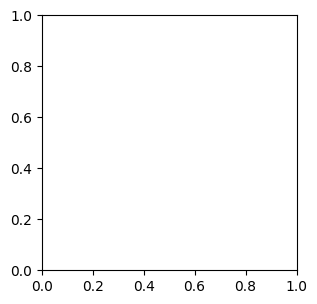

In [57]:
plt = test_env.render(camera_position,
                     c='white',
                     s=20,
                     lw=1,
                     normalize_cbars=True,
                     cmap=cmc.roma,
                     add_streamplot=True,
                     streamplot_density=3,
                     streamplot_color='k',
                     streamplot_linewidth=0.3,
                     figsize=(15,6), 
                     filename=None)

### Visualize the learned policy in the test environment

Create sparse samples of camera position on a uniform grid:

In [ ]:
(_, _, H, W) = test_env.flowfield.velocity_field_magnitude.shape
(H_adm, W_adm) = test_env.admissible_observation_space
idx_H = [i for i in range(0, H_adm) if i % 1 == 0]
idx_W = [i for i in range(0, W_adm) if i % 1 == 0]
print(len(idx_H) * len(idx_W))

In [ ]:
tic = time.perf_counter()

learned_policy = np.ones((H,W)) * np.nan

for h in idx_H:
    for w in idx_W:

        camera_position = np.array([h, w])
        _, cues = test_env.reset(imposed_camera_position=camera_position)
        q_values = ca.online_q_network(cues)
        action = np.argmax(q_values)
        learned_policy[h, w] = action

learned_policy = learned_policy[~np.isnan(learned_policy)]
learned_policy = learned_policy.reshape(len(idx_H), len(idx_W))

toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic):0.1f} sec.')

In [ ]:
from matplotlib.colors import ListedColormap
cluster_colors = cmc.batlow(np.linspace(0, 1, 5))
cmap = ListedColormap(cluster_colors)

plt.figure(figsize=(20,10))
plt.imshow(learned_policy, origin='lower', cmap=cmap, vmin=0, vmax=4)
cbar = plt.colorbar()
cbar.set_ticks([4/5*(i+0.5) for i in range(0,5)])
cbar.set_ticklabels(list(test_env.action_to_verbose_direction.values()))
plt.xticks([i for i in range(0,len(idx_W))], idx_W, rotation=90)
plt.yticks([i for i in range(0,len(idx_H))], idx_H);
# plt.xlim([90,110])
# plt.ylim([0,20])
plt.savefig('tested-policy.png', dpi=300, bbox_inches='tight')

### Visualize one sample trajectory in the test environment

We are going to take a number of steps in the environment:

In [ ]:
n_steps = 100

In [ ]:
saved_camera_trajectories = np.zeros((n_steps,2))

In [ ]:
camera_position, cues = test_env.reset(imposed_camera_position=(60,100))

In [ ]:
for i in range(0,n_steps):

    saved_camera_trajectories[i, 0] = camera_position[0]
    saved_camera_trajectories[i, 1] = camera_position[1]

    q_values = ca.online_q_network(cues)

    action = np.argmax(q_values)

    print(test_env.action_to_verbose_direction[action])

    camera_position, cues, reward = test_env.step(action=action,
                                                  reward_function=reward_function,
                                                  reward_transformation=reward_transformation,
                                                  magnify_step=10,
                                                  verbose=False)

In [ ]:
plot_trajectory(test_env.flowfield.velocity_field,
                saved_camera_trajectories,
                interrogation_window_size=interrogation_window_size,
                c_path='white',
                c_init='white',
                c_final='black',
                s=20,
                lw=2,
                xlabel=None,
                ylabel=None,
                xticks=True,
                yticks=True,
                cmap=cmc.roma,
                add_streamplot=True,
                streamplot_density=4,
                streamplot_color='k',
                streamplot_linewidth=0.4,
                figsize=(15,5),
                dpi=300,
                filename=None);

***

## Upload the Q-network trained on the cluster

Upload the displacement field:

In [ ]:
# path = '/Users/kamilazdybal/GitLab-Empa/pykitPIV/CHPC/RUN-TEST/TEST-'
# path = '/Users/kamilazdybal/GitLab-Empa/pykitPIV/scripts/TEST-'
path = '/Users/kamilazdybal/Desktop/RUN-first-successful-non-normalized-d/large-lr-'

velocity_u = pd.read_csv(path + 'final-velocity-field-u.csv', sep = ',', header=None).to_numpy()
velocity_v = pd.read_csv(path + 'final-velocity-field-v.csv', sep = ',', header=None).to_numpy()

user_velocity = np.zeros((1,2,200,300))
user_velocity[0,0,:,:] = velocity_u
user_velocity[0,1,:,:] = velocity_v

In [ ]:
from pykitPIV import FlowField

user_flowfield = FlowField(n_images=1,
                      size=(200, 300),
                      size_buffer=0,
                      random_seed=100)

user_flowfield.upload_velocity_field(user_velocity)

In [ ]:
flowfield_spec = FlowFieldSpecs(size=(100, 100),
                                flowfield_type='random smooth',
                                gaussian_filters=(10, 10),
                                n_gaussian_filter_iter=10,
                                displacement=(2, 2))

print(flowfield_spec)

In [ ]:
env = PIVEnv(interrogation_window_size=interrogation_window_size,
             interrogation_window_size_buffer=0,
             cues_function=cues_function,
             particle_spec=particle_spec,
             motion_spec=motion_spec,
             image_spec=image_spec,
             flowfield_spec=flowfield_spec,
             inference_model=None,
             user_flowfield=None,
             random_seed=None)

In [ ]:
camera_position, cues = env.reset()

In [ ]:
cues.shape

In [ ]:
plt = env.render(camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma_r,
                 add_streamplot=True,
                 streamplot_density=3,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(10,6), 
                 filename='final-environment.png')

In [ ]:
trained_q_network = QNetwork(n_actions=env.n_actions, kernel_initializer = tf.keras.initializers.RandomUniform)
_ = trained_q_network(tf.ones((1, env.n_cues)))

In [ ]:
# trained_q_network.load_weights('QNetwork.keras')

In [ ]:
trained_q_network.load_weights(path + 'QNetwork.keras')

Make inference:

In [ ]:
(_, _, H, W) = env.flowfield.velocity_field_magnitude.shape
(H_adm, W_adm) = env.admissible_observation_space
idx_H = [i for i in range(0, H_adm) if i % 1 == 0]
idx_W = [i for i in range(0, W_adm) if i % 1 == 0]
print(len(idx_H) * len(idx_W))

In [ ]:
tic = time.perf_counter()

learned_policy = np.ones((H,W)) * np.nan

for h in idx_H:
    for w in idx_W:

        camera_position = np.array([h, w])
        _, cues = env.reset(imposed_camera_position=camera_position)
        q_values = trained_q_network(cues)
        action = np.argmax(q_values)
        learned_policy[h, w] = action

learned_policy = learned_policy[~np.isnan(learned_policy)]
learned_policy = learned_policy.reshape(len(idx_H), len(idx_W))

toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic):0.1f} sec.')

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(learned_policy, origin='lower', cmap=cmap_actions, vmin=0, vmax=4)
cbar = plt.colorbar()
cbar.set_ticks([4/5*(i+0.5) for i in range(0,5)])
cbar.set_ticklabels(list(env.action_to_verbose_direction.values()))
# plt.xticks([i for i in range(0,len(idx_W))], idx_W, rotation=90)
# plt.yticks([i for i in range(0,len(idx_H))], idx_H);

***

© K. Zdybał, C. Mucignat, S. Kunz, I. Lunati (2025)